# Satellite Data

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/03_data/01_satellite.ipynb).

This page (and indeed, this entire section) could perhaps be considered an advanced topic. There is nothing stopping you downloading your data from a traditional GUI source (e.g. Landsat data from https://earthexplorer.usgs.gov/) and loading your datasets in using `rioxarray`, as explored in a previous section.

However, one of the reasons we want to learn programming is so that we can apply our analysis to very large datasets. The first aspect of this is to learn how we can _download_ very large datasets, particularly in efficient manners. For instance, we might want to download 500 Landsat images of a glacier, but we don't necessarily need to download 500 full Landsat scenes from EarthExplorer: perhaps we only need a specific small area, and maybe we only need a few bands. This is what interacting with data programatically aims to make efficient and easy.

## Introducing STACs

Interacting with a remote source of data normally requires something called an Application Programming Interface (API) - a little bit of software on an organsiations website that other remote programs can come and talk to (making _requests_ and receiving a _response_ from the API). 

Many organisations have tried - and failed - to produce workable APIs for large-scale satellite data, and it was all becoming a bit of a mess. Luckily, there has been a recent consolidation around [Spatio-Temporal Asset Catalogues (STACs)](https://stacspec.org/en/): a standardised specification of structuring and organising geospatial data. Think of it a Dewey decimal system for geospatial data, so that no matter who is hosting the library, we know that we can walk in and the data will be organised exactly the same as in all other libraries.

As a result, we know longer need to learn how to use Python to a load of different interfaces: we only need to learn one interface (the STAC, and in particular `pystac_client`), and change who we are pointing to. This is a recent but rapidly growing area: I can't promise you that everyone has a STAC, and there will be some variation (for instance, in the ice velocity and altimetry notebooks), but enough people have it that you can learn this method and download a vast range of geospatial data, including the Landsat and Sentinel (optical and radar) programmes and global DEM datasets (including ArcticDEM and REMA).

## Searching for Optical Data in STACs

### The Microsoft Planetary Computer STAC

Organisations with STACs include the USGS via LandsatLook, ESA/Copernicus (in progress), the Polar Geospatial Center, and OpenTopography. However, my first point of call is to consult [the Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/?lang=en) STAC. Here, Microsoft has hosted petabytes of data in analysis-ready formats. You can take a look at what is available to search in [the catalog](https://planetarycomputer.microsoft.com/catalog).

Data can be downloaded 'anonymously' (i.e. without registration), but download speeds may be throttled unless you can properly sign your requests. This is made easy for us through a very small additional package, unique to the MPC STAC, called `planetary_computer`. We can install it in the usual way, alongside the essential `pystac_client` whilst we're at it:

```sh
conda install planetary-computer pystac-client
```

### Connecting to a STAC

We connect to a STAC using the `pystac_client`. We will need to URL link to the dynamic STAC, which will be available on various documentation. As mentioned, we use an additional magic bit of `planetary_computer` to facilitate our access to the MPC (other STACs will not have this):

In [161]:
import pystac_client
import planetary_computer  # only needed for MPC

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,  # only needed for MPC
)

In [162]:
catalog

<Client id=microsoft-pc>

It's challenging to understand what's going on with this returned object, but at least we know we've succesfully connected.

Now, we can search individual collections. We can see all the collections in the [MPC catalogue](https://planetarycomputer.microsoft.com/catalog), and individual collections will show us more data. For instance, at the [Landsat Collection-2 Level-2 site](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2), we can see that the collection name is `landsat-c2-l2`, as well as the various "assets" contained within the dataset, such as all the bands and metadata.

We can assess the collection by getting it as a variable:

In [163]:
collection = catalog.get_collection("landsat-c2-l2")
collection

<CollectionClient id=landsat-c2-l2>

Particularly useful submenues here are the `item_assets` and `summaries` tabs, where you can see what bands are available.

### Searching a STAC

We can search the catalogue using a standardised search tool. There are always some consistent things you can search a STAC catalogue for, including `time_range` and some sort of spatial search - which could be `bbox` in the form of `[xmin, ymin, xmax, ymax]`, or using the `intersects` parameter by feeding a GeoJSON or shapely geometry feature. All will work in lat/lon only, as this is how STACs are spatially indexed.

Let's search for coverage of Helheim. We will ultimately want to work in Polar Stereographic North, so we will begin with a bounding box in this format and convert to a WGS84 lat/lon version.

In [164]:
import geopandas as gpd
from shapely.geometry import box

issunguata_bounds_3413 = -235000,-2497000,-217000,-2489000

issunguata_gdf_3413 = gpd.GeoDataFrame(geometry=[box(*issunguata_bounds_3413)], crs="epsg:3413")
issunguata_gdf_4326 = issunguata_gdf_3413.to_crs(4326)

issunguata_bounds_4326 = issunguata_gdf_4326.geometry.values[0].bounds

# Get EPSG:4326 geometry for feeding in to STAC search
issunguata_4326_geom = issunguata_gdf_4326.geometry.values[0]

Now let's get a search set up. 

In [165]:

collection = "landsat-c2-l2"
time_range = "2024-05-01/2024-09-01"
geom = issunguata_4326_geom

search = catalog.search(
    collections=[collection],
    intersects=geom,
    datetime=time_range,
)

# Check how many items were returned
items = search.item_collection()
print(f"Query returns {len(items)} Items")

Query returns 74 Items


23 valid items have been returned. Let's take a look at what the first result looks like:

In [166]:
item = items[0]
item

<Item id=LC09_L2SP_008013_20240901_02_T2>

One thing I haven't mentioned yet is that each `item` will have its own set of properties:

In [167]:
item.properties

{'gsd': 30,
 'created': '2024-10-05T09:21:19.459948Z',
 'sci:doi': '10.5066/P9OGBGM6',
 'datetime': '2024-09-01T14:54:58.857174Z',
 'platform': 'landsat-9',
 'proj:shape': [8501, 8451],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['oli', 'tirs'],
 'eo:cloud_cover': 100.0,
 'proj:transform': [30.0, 0.0, 372285.0, 0.0, -30.0, 7551615.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '013',
 'landsat:scene_id': 'LC90080132024245LGN00',
 'landsat:wrs_path': '008',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 171.66797215,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 30.80181717,
 'landsat:cloud_cover_land': 100.0,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T2',
 'proj:code': 'EPSG:32622'}

We can actually use these additional variables to build `query` dictionary. Some are specific to each dataset (for instance, sentinel-2 has things like `s2:high_proba_clouds_percentage` and `s2:mean_solar_zenith`) so it's always worth checking what you can search for. Here, we will filter by cloud cover as well.

In [168]:

collection = "landsat-c2-l2"
time_range = "2024-05-01/2024-09-01"
geom = issunguata_4326_geom

query = {
    'eo:cloud_cover': {'lt': 20},
}


search = catalog.search(
    collections=[collection],
    intersects=geom,
    datetime=time_range,
    query=query
)

# Check how many items were returned
items = search.item_collection()
print(f"Query returns {len(items)} Items")

Query returns 9 Items


Great, we have fewer items that we know have good cloud cover! 

By the way, we can turn this collection into a `geopandas` dataframe quite easily:

In [169]:
import geopandas as gpd

gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
gdf.head()

geometry  gsd  \
0  POLYGON ((-49.10524 68.06278, -50.71572 66.429...   30   
1  POLYGON ((-49.09661 68.06268, -50.70765 66.429...   30   
2  POLYGON ((-49.12108 68.06269, -50.73185 66.429...   30   
3  POLYGON ((-50.64244 68.06599, -52.25356 66.433...   30   
4  POLYGON ((-52.20438 69.41556, -53.99877 67.795...   30   

                       created           sci:doi                     datetime  \
0  2024-08-21T09:26:53.802302Z  10.5066/P9OGBGM6  2024-08-18T14:42:31.942338Z   
1  2024-08-05T09:19:37.915424Z  10.5066/P9OGBGM6  2024-08-02T14:42:22.180035Z   
2  2024-07-20T09:28:49.588722Z  10.5066/P9OGBGM6  2024-07-17T14:42:19.059837Z   
3  2024-07-25T09:21:42.432873Z  10.5066/P9OGBGM6  2024-07-16T14:48:33.406055Z   
4  2024-07-11T09:11:48.415619Z  10.5066/P9OGBGM6  2024-06-28T15:00:17.753659Z   

    platform    proj:shape                   description  instruments  \
0  landsat-9  [8321, 8261]  Landsat Collection 2 Level-2  [oli, tirs]   
1  landsat-9  [8321, 8261]  Landsat Collection 2 Level-2  [oli, tirs]   
2  landsat-9  [8311, 8271]  Landsat Collection 2 Level-2  [oli, tirs]   
3  landsat-8  [8411, 8361]  Landsat Collection 2 Level-2  [oli, tirs]   
4  landsat-8  [8581, 8521]  Landsat Collection 2 Level-2  [oli, tirs]   

   eo:cloud_cover  ...       landsat:scene_id  landsat:wrs_path  \
0            5.12  ...  LC90060132024231LGN00               006   
1            0.08  ...  LC90060132024215LGN00               006   
2            1.85  ...  LC90060132024199LGN00               006   
3            5.32  ...  LC80070132024198LGN00               007   
4           14.90  ...  LC80090122024180LGN00               009   

  landsat:wrs_type view:sun_azimuth landsat:correction view:sun_elevation  \
0                2       170.124486               L2SP          35.585436   
1                2       168.874109               L2SP          40.248633   
2                2       168.438339               L2SP          43.745747   
3                2       168.508718               L2SP          43.921915   
4                2       171.200668               L2SP          44.757913   

   landsat:cloud_cover_land landsat:collection_number  \
0                      5.12                        02   
1                      0.08                        02   
2                      1.85                        02   
3                      5.26                        02   
4                     15.14                        02   

   landsat:collection_category   proj:code  
0                           T1  EPSG:32622  
1                           T1  EPSG:32622  
2                           T1  EPSG:32622  
3                           T1  EPSG:32622  
4                           T1  EPSG:32622  

[5 rows x 23 columns]

We can also turn the dataframe back into a pystac `ItemCollection`. I do this to do additional filtering by creating new searchable variables not present in the original metadata. You don't have to do this all the time, but here is a snippet of script where I convert into a `geopandas` dataframe and filter by the fractional coverage of the original AOI bounding box. I've also done thinks like filtering only to months between the user-provided values of `month_min` and `month_max` (this is useful if we only e.g. want to download summer months across multiple years).

In [170]:
from pystac import ItemCollection
import numpy as np

# Filter only to scenes where fractional coverage of AOI exceeds desired threshold
aoi_frac_thresh = .7  # 70% minimum

# convert to polar stereographic so we can work in meters
gdf = gdf.to_crs(3413).clip(issunguata_gdf_3413)

gdf = gdf.sort_index()
gdf["frac"] = gdf.area / helheim_gdf_3413.area.values[0]
gdf["exceed_frac"] = np.where(gdf["frac"].values >= aoi_frac_thresh, True, False)

items_list = []
for i, exceed_frac in zip(items, gdf.exceed_frac.values):
    if exceed_frac == True:
        items_list.append(i)

items_aoi_filtered = ItemCollection(items=items_list)
print(f"Afer ROI filtering, returns {len(items_aoi_filtered)} Items")

Afer ROI filtering, returns 3 Items


## Downloading Data from a STAC

### Download Individual Data

Now that we have our search results, let's pick just the first item and see what assets we have available to download:

In [129]:
item = items_aoi_filtered[0]
print(item.id)
print(item.assets.keys())

LC08_L2SP_007013_20240716_02_T1
dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


We can preview the item using the `rendered_preview` item and Python's simply in-built image display. Note that `href` means the HTTP reference.

In [130]:
from IPython.display import Image

Image(url=item.assets["rendered_preview"].href, width=500)

Looks good! We can now get individual bands via the `href` of their assets, loading with `rioxarray`. Note that they are not stored in EPSG:4326, they are stored in whatever the appropriate UTM projection is. Therefore, before we clip the data, we must convert our geopandas boundary into the appropriate CRS.

In [139]:
import rioxarray as rxr

# 'Squeeze' is a useful function to remove dimensions of size 1 ('band' in this 
# case, as we only have one band, red)
xds = rxr.open_rasterio(item.assets['red'].href).squeeze()

# Note that our data is stored in a UTM projection
print(xds.rio.crs)

# Clip the data, after convertin our geodataframe to the same projection
xds = xds.rio.clip(
    issunguata_gdf_3413.to_crs(xds.rio.crs).geometry.values
)

EPSG:32622


Now, we have got a useful bit of data:

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

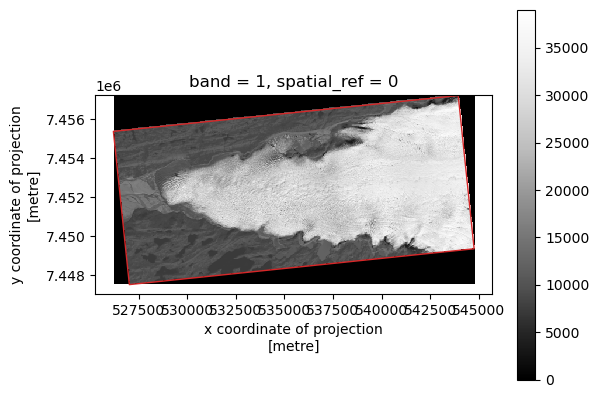

In [140]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
xds.plot.imshow(cmap='Greys_r', ax=ax)
issunguata_gdf_3413.to_crs(32622).plot(ax=ax, fc='none', ec='tab:red')

> `TODO`: convert from DN to reflectance. This will also fix the slightly dodgy NDSI values below.

Now, we could go through this charade for every single band we want and stack them together, but there is actually an easier option, using a package called `stackstac`.

### Batch download with `stackstac`

`stackstac` allows us to provide the individual assets we want, a target CRS, target resolution, bounds, and even a method of resampling (which we will do using legacy `rasterio` function calls). It will provide a single large `xarray` of all our data, allowing us to pick the dates we want.

In [212]:
issunguata_gdf_3413.to_crs(32622).total_bounds.tolist()
# issunguata_bounds_3413

[526206.6761875935, 7447501.881333968, 544757.4277271645, 7457226.07411013]

In [216]:
import stackstac
from rasterio.enums import Resampling

# Prep our chosen parameters
resampling = Resampling.cubic
assets = ['red', 'green', 'blue', 'swir16']
working_resolution = 30
target_crs = 3413
bounds = issunguata_bounds_3413

# Stack our data
data = stackstac.stack(
    items_aoi_filtered,
    assets=assets,
    resolution=working_resolution,
    epsg=target_crs,
    resampling=resampling,
    bounds=bounds,
    chunksize=512,  # for parallel processing
)

data

<xarray.DataArray 'stackstac-8021831003edc1a707c2bfeb1e58e179' (time: 3,
                                                                band: 4,
                                                                y: 268, x: 601)> Size: 15MB
dask.array<fetch_raster_window, shape=(3, 4, 268, 601), dtype=float64, chunksize=(1, 1, 268, 512), chunktype=numpy.ndarray>
Coordinates: (12/30)
  * time                         (time) datetime64[ns] 24B 2024-05-11T15:00:1...
    id                           (time) <U31 372B 'LC08_L2SP_009012_20240511_...
  * band                         (band) <U6 96B 'red' 'green' 'blue' 'swir16'
  * x                            (x) float64 5kB -2.35e+05 ... -2.17e+05
  * y                            (y) float64 2kB -2.489e+06 ... -2.497e+06
    description                  (band) <U77 1kB 'Collection 2 Level-2 Red Ba...
    ...                           ...
    title                        (band) <U28 448B 'Red Band' ... 'Short-wave ...
    raster:bands                 object 8B {'scale': 2.75e-05, 'nodata': 0, '...
    common_name                  (band) <U6 96B 'red' 'green' 'blue' 'swir16'
    center_wavelength            (band) float64 32B 0.65 0.56 0.48 1.61
    full_width_half_max          (band) float64 32B 0.04 0.06 0.06 0.09
    epsg                         int64 8B 3413
Attributes:
    spec:        RasterSpec(epsg=3413, bounds=(-235020, -2497020, -216990, -2...
    crs:         epsg:3413
    transform:   | 30.00, 0.00,-235020.00|\n| 0.00,-30.00,-2488980.00|\n| 0.0...
    resolution:  30

Fantastic. You can see our `data` object is another multidimensional xarray object with four indexes: `x`, `y`, `band`, and `time`.

It appeared instantly because `xarray` is still lazily evaluating the data. Let's get the same dataset again, this time in a slightly different way (why not) by trying to find the specific day from earlier.

In [217]:

scene = data.sel(time="2024-07-16").squeeze()

scene

<xarray.DataArray 'stackstac-8021831003edc1a707c2bfeb1e58e179' (band: 4,
                                                                y: 268, x: 601)> Size: 5MB
dask.array<getitem, shape=(4, 268, 601), dtype=float64, chunksize=(1, 268, 512), chunktype=numpy.ndarray>
Coordinates: (12/30)
    time                         datetime64[ns] 8B 2024-07-16T14:48:33.406055
    id                           <U31 124B 'LC08_L2SP_007013_20240716_02_T1'
  * band                         (band) <U6 96B 'red' 'green' 'blue' 'swir16'
  * x                            (x) float64 5kB -2.35e+05 ... -2.17e+05
  * y                            (y) float64 2kB -2.489e+06 ... -2.497e+06
    description                  (band) <U77 1kB 'Collection 2 Level-2 Red Ba...
    ...                           ...
    title                        (band) <U28 448B 'Red Band' ... 'Short-wave ...
    raster:bands                 object 8B {'scale': 2.75e-05, 'nodata': 0, '...
    common_name                  (band) <U6 96B 'red' 'green' 'blue' 'swir16'
    center_wavelength            (band) float64 32B 0.65 0.56 0.48 1.61
    full_width_half_max          (band) float64 32B 0.04 0.06 0.06 0.09
    epsg                         int64 8B 3413
Attributes:
    spec:        RasterSpec(epsg=3413, bounds=(-235020, -2497020, -216990, -2...
    crs:         epsg:3413
    transform:   | 30.00, 0.00,-235020.00|\n| 0.00,-30.00,-2488980.00|\n| 0.0...
    resolution:  30

We can now plot the scene - in order to get an RGB plot, we will select only the `['red', 'green', 'blue']` bands in order:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1999725..1.0468775000000001].


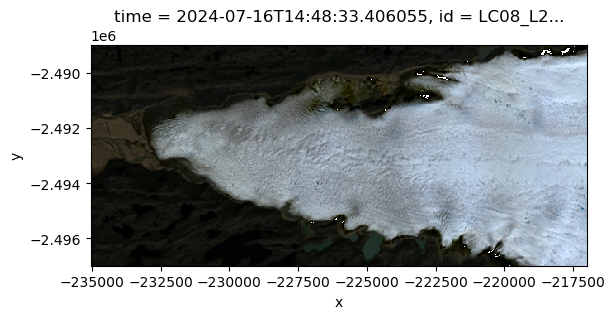

In [218]:
# Force download the scene
scene = scene.compute()

# Get a three-band image
rgb = scene.sel(band=['red', 'green', 'blue'])

# Plot this
fig, ax = plt.subplots()
rgb.plot.imshow(ax=ax)
ax.set_aspect('equal')

Note that `imshow` compalined a bit because it expects reflectance values between 0-1 or 8-bit values between 0 and 255. Over ice surfaces with drastic changes in reflectance, you can get values beyond this!

Anyway, let's do something useful and calculate NDSI! Recall the NDSI equation is

$$NDSI = \frac{Green - SWIR}{Green + SWIR}.$$

We can work this out as follows:


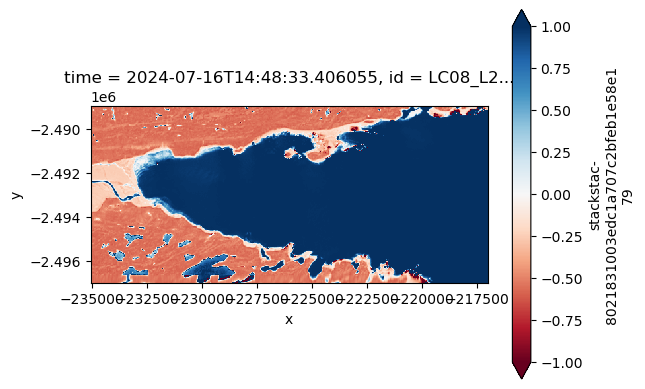

In [229]:
ndsi = (
    (scene.sel(band='green') - scene.sel(band='swir16'))
    / (scene.sel(band='green') + scene.sel(band='swir16'))
)

fig, ax = plt.subplots()
ndsi.plot.imshow(ax=ax, vmin=-1, vmax=+1, cmap='RdBu')
ax.set_aspect('equal')
plt.show()

Neat. Remember we can also use other `xarray` functions to manipulate the data (e.g. getting a long-term average of pixel values).

Most importantly, you might wish to download the data we've got in the stack. An example here would look through the stack along the time axis, saving according to the scene ID name. I haven't set a directory or anything here though.

```python
for i in len(data):
    
    scene = data.isel(time=i)
    scene_fname = f"{scene.id.item}.tif"
    scene.compute()

    # export cog with zstd compression
    scene.rio.to_raster(scene_fname, driver='COG', compress='zstd')
```